[Batch 1] loss=0.050, avg10_reward=16.4
[Batch 2] loss=0.996, avg10_reward=14.8
[Batch 3] loss=1.083, avg10_reward=16.1
[Batch 4] loss=0.378, avg10_reward=19.9
[Batch 5] loss=-0.097, avg10_reward=28.3
[Batch 6] loss=-0.100, avg10_reward=38.5
[Batch 7] loss=0.149, avg10_reward=32.7
[Batch 8] loss=0.380, avg10_reward=34.8
[Batch 9] loss=-0.143, avg10_reward=30.3
[Batch 10] loss=-0.591, avg10_reward=28.1
[Batch 11] loss=-0.088, avg10_reward=57.4
[Batch 12] loss=-0.710, avg10_reward=62.8
[Batch 13] loss=-0.348, avg10_reward=52.1
[Batch 14] loss=-0.293, avg10_reward=59.6
[Batch 15] loss=-0.205, avg10_reward=45.5
[Batch 16] loss=1.310, avg10_reward=41.4
[Batch 17] loss=0.243, avg10_reward=57.4
[Batch 18] loss=-0.367, avg10_reward=53.5
[Batch 19] loss=0.913, avg10_reward=48.9
[Batch 20] loss=-0.750, avg10_reward=59.4
[Batch 21] loss=0.363, avg10_reward=78.9
[Batch 22] loss=0.226, avg10_reward=54.5
[Batch 23] loss=-1.135, avg10_reward=68.6
[Batch 24] loss=0.725, avg10_reward=72.4
[Batch 25] lo

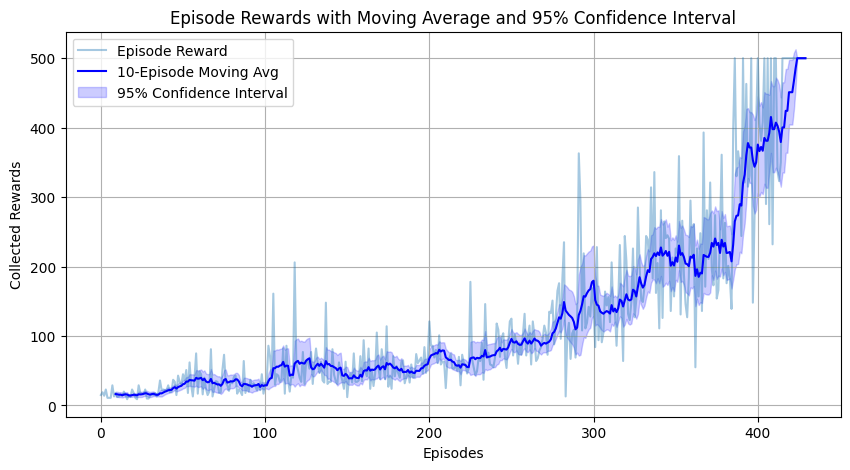

In [57]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import random
import matplotlib.pyplot as plt

SEED = 40
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PolicyNet(nn.Module) :
    def __init__(self, state_dim, action_dim, hidden_dim=128) :
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1),
        )
    def forward(self, x) :
        return self.net(x)

def select_action(policy, state) :
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    probs = policy(state)
    m = Categorical(probs)
    a = m.sample()
    return a.item(), m.log_prob(a)

def compute_returns(rewards, gamma=0.999) :
    R, returns = 0.0, []
    for r in reversed(rewards) :
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32, device=DEVICE)
    return (returns - returns.mean()) / (returns.std() + 1e-8)

def reinforce_update_batch(states, actions, returns, policy, optimizer, batch_size) :
    S = torch.tensor(states, dtype=torch.float32, device=DEVICE)
    A = torch.tensor(actions, dtype=torch.long,    device=DEVICE)
    G = torch.tensor(returns, dtype=torch.float32, device=DEVICE)

    probs = policy(S)
    logp = torch.log(probs.gather(1, A.unsqueeze(1)).squeeze(1) + 1e-9)
    loss = -(logp * G).sum() / batch_size

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def train_pg_batch(env_name='CartPole-v1',
                   total_episodes=1000,
                   batch_size=10,    
                   gamma=0.99,
                   lr=1e-2) :
    env = gym.make(env_name)
    env.action_space.seed(SEED)
    env.observation_space.seed(SEED)

    state_dim  = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy    = PolicyNet(state_dim, action_dim).to(DEVICE)
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    episode_rewards = []
    decay_streak    = 0
    tolerance       = 5

    for batch_start in range(0, total_episodes, batch_size) :
        batch_states, batch_actions, batch_returns = [], [], []
        for ep in range(batch_size) :
            state, _ = env.reset(seed=SEED + batch_start + ep)
            done = False
            traj_states, traj_actions, traj_rewards = [], [], []

            while not done :
                a, logp = select_action(policy, state)
                step = env.step(a)
        
                obs, r, term, trunc, _ = step
                done = term or trunc

                traj_states.append(state)
                traj_actions.append(a)
                traj_rewards.append(r)
                state = obs

            returns = compute_returns(traj_rewards, gamma).cpu().numpy()
            batch_states  .extend(traj_states)
            batch_actions .extend(traj_actions)
            batch_returns .extend(returns.tolist())

            episode_rewards.append(sum(traj_rewards))

        loss = reinforce_update_batch(
            batch_states, batch_actions, batch_returns,
            policy, optimizer, batch_size
        )

        avg10 = np.mean(episode_rewards[-10:])
        print(f'[Batch {(batch_start//batch_size)+1}] loss={loss:.3f}, avg10_reward={avg10:.1f}')

        if len(episode_rewards) >= 20 :
            prev10 = np.mean(episode_rewards[-20:-10])
            if prev10 - avg10 >= 10 :
                decay_streak += 1
            else:
                decay_streak = 0
        if avg10 >= 500.0 or decay_streak >= tolerance :
            status = 'Problem Solved!' if avg10 >= 500.0 else 'Detected decay!'
            print(f'Stopping training – {status}')
            break

    return episode_rewards, policy

if __name__ == "__main__" :
    rewards, policy = train_pg_batch(env_name='CartPole-v1',
                             total_episodes=1000,
                             batch_size=10,
                             gamma=0.999,
                             lr=1e-2)
    plot_with_moving_average_and_ci(rewards, window=10)

In [53]:
from PIL import Image

def render_policy_to_gif(policy, env_name='CartPole-v1', save_path='cartpole.gif',
                         episodes=1, max_steps=500, state_bounds=None) :
    env = gym.make(env_name, render_mode='rgb_array')
    frames = []

    policy.eval()
    
    for ep in range(episodes) :
        state, _ = env.reset(seed=SEED + ep)
        done = False

        for step in range(max_steps) :
            frame = env.render()
            frames.append(Image.fromarray(frame))
            
            s = state if state_bounds is None else state / state_bounds
            s_tensor = torch.tensor(s, dtype=torch.float32, device=DEVICE).unsqueeze(0)

            with torch.no_grad() :
                probs = policy(s_tensor)
            action = torch.argmax(probs).item()

            state, reward, term, trunc, _ = env.step(action)
            done = term or trunc
            if done :
                break

    env.close()

    frames[0].save(save_path, save_all=True, append_images=frames[1:],
                   optimize=False, duration=40, loop=0)
    print(f"Saved GIF to {save_path}")

In [54]:
state_bounds = np.array([2.4, 2.5, 0.21, 2.5])

render_policy_to_gif(policy, env_name='CartPole-v1',
                     save_path='gym_CartPole.gif',
                     episodes=1, max_steps=500,
                     state_bounds=state_bounds)

Saved GIF to gym_CartPole.gif
